In [1]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

# กำหนด path ไปยังโฟลเดอร์ใน Drive
drive_folder = '/content/drive/MyDrive/dataset_aibuilders_2'

# รายชื่อไฟล์ zip ที่จะโหลด
zip_files = ['Salmon.zip', 'Trout.zip']

# โฟลเดอร์ปลายทาง
extract_folder = '/content/dataset'

# สร้างโฟลเดอร์ปลายทางถ้ายังไม่ได้สร้าง
os.makedirs(extract_folder, exist_ok=True)

# โหลดแล้วแตกไฟล์ zip ทีละอัน
for zip_name in zip_files:
    zip_path = os.path.join(drive_folder, zip_name)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        print(f'แตกไฟล์ {zip_name} เสร็จแล้วอยู่ที่ {extract_folder}')


แตกไฟล์ Salmon.zip เสร็จแล้วอยู่ที่ /content/dataset
แตกไฟล์ Trout.zip เสร็จแล้วอยู่ที่ /content/dataset


In [3]:
import numpy as np
from torchvision import datasets, transforms

# กำหนด path ของ dataset
data_dir = '/content/dataset'

# สร้าง image transform สำหรับ preprocess
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ปรับขนาดให้เหมาะกับ ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize RGB ทั้ง 3 ช่อง
])

# โหลด dataset โดยใช้ ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# ดึง label ทั้งหมดออกมาเพื่อใช้ใน k-fold
labels = np.array([label for _, label in dataset.samples])


In [4]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

#เตรียม k-fold

# กำหนดจำนวน fold
num_folds = 5

# สร้าง Stratified K-Fold
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np

# === เพิ่ม Data Augmentation ===
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset.transform = None  # ปิดไว้ก่อน

In [6]:
import torch
import torch.nn as nn
from torchvision import models

def create_model(num_classes=2):
    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
num_folds = 5

# Loop K-Fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\n Fold {fold+1}/{num_folds}")

    # Apply transform เฉพาะตอนสร้าง Subset
    dataset.transform = train_transform
    train_subset = Subset(dataset, train_idx)

    dataset.transform = val_transform
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = create_model(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Evaluate
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), f'model_fold_{fold}.pth')


 Fold 1/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Train Loss: 0.7236 | Val Acc: 0.5000
Epoch 2/10 | Train Loss: 0.2861 | Val Acc: 0.5588
Epoch 3/10 | Train Loss: 0.2145 | Val Acc: 0.5441
Epoch 4/10 | Train Loss: 0.2517 | Val Acc: 0.8382
Epoch 5/10 | Train Loss: 0.3273 | Val Acc: 0.5294
Epoch 6/10 | Train Loss: 0.2619 | Val Acc: 0.7059
Epoch 7/10 | Train Loss: 0.2428 | Val Acc: 0.8382
Epoch 8/10 | Train Loss: 0.1685 | Val Acc: 0.8824
Epoch 9/10 | Train Loss: 0.1072 | Val Acc: 0.9265
Epoch 10/10 | Train Loss: 0.0999 | Val Acc: 0.9559

 Fold 2/5
Epoch 1/10 | Train Loss: 0.6296 | Val Acc: 0.5000
Epoch 2/10 | Train Loss: 0.4502 | Val Acc: 0.6324
Epoch 3/10 | Train Loss: 0.3274 | Val Acc: 0.5882
Epoch 4/10 | Train Loss: 0.2147 | Val Acc: 0.7353
Epoch 5/10 | Train Loss: 0.2348 | Val Acc: 0.9412
Epoch 6/10 | Train Loss: 0.2476 | Val Acc: 0.9118
Epoch 7/10 | Train Loss: 0.1957 | Val Acc: 0.8235
Epoch 8/10 | Train Loss: 0.1532 | Val Acc: 0.9118
Epoch 9/10 | Train Loss: 0.1348 | Val Acc: 0.9265
Epoch 10/10 | Train Loss: 0.0811 | Val

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
data_dir = "/content/dataset"

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
labels = [label for _, label in dataset.samples]
labels = np.array(labels)

# K-Fold config
k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []

# เริ่มตรวจสอบแต่ละ Fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\n Evaluating Fold {fold+1}")

    # สร้าง validation subset
    val_subset = Subset(dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=32)

    # โหลดโมเดล
    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(f'/content/model_fold_{fold}.pth', map_location=device))
    model = model.to(device)
    model.eval()

    # ประเมินผล
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    acc = correct / total
    fold_accuracies.append(acc)
    print(f" Fold {fold+1} Accuracy: {acc:.4f}")

# สรุป
print("\n Accuracy ของแต่ละ Fold:")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")

avg_acc = np.mean(fold_accuracies)
print(f"\n Average Accuracy: {avg_acc:.4f}")


 Evaluating Fold 1
 Fold 1 Accuracy: 0.4853

 Evaluating Fold 2
 Fold 2 Accuracy: 0.5000

 Evaluating Fold 3
 Fold 3 Accuracy: 0.5147

 Evaluating Fold 4
 Fold 4 Accuracy: 0.4265

 Evaluating Fold 5
 Fold 5 Accuracy: 0.4706

 Accuracy ของแต่ละ Fold:
Fold 1: 0.4853
Fold 2: 0.5000
Fold 3: 0.5147
Fold 4: 0.4265
Fold 5: 0.4706

 Average Accuracy: 0.4794


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedKFold
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
data_dir = "/content/dataset"

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
labels = [label for _, label in dataset.samples]
labels = np.array(labels)

# K-Fold config
k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_losses = []

# Loss function
criterion = nn.CrossEntropyLoss()

# เริ่มตรวจสอบแต่ละ Fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\n Evaluating Fold {fold+1}")

    # สร้าง validation subset
    val_subset = Subset(dataset, val_idx)
    val_loader = DataLoader(val_subset, batch_size=32)

    # โหลดโมเดล
    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(f'/content/model_fold_{fold}.pth', map_location=device))
    model = model.to(device)
    model.eval()

    # ประเมินผล (Loss)
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_size = targets.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    fold_losses.append(avg_loss)
    print(f" Fold {fold+1} Loss: {avg_loss:.4f}")

# สรุป
print("\n Loss ของแต่ละ Fold:")
for i, loss in enumerate(fold_losses):
    print(f"Fold {i+1}: {loss:.4f}")

avg_loss = np.mean(fold_losses)
print(f"\n Average Loss: {avg_loss:.4f}")



 Evaluating Fold 1
 Fold 1 Loss: 1.8362

 Evaluating Fold 2
 Fold 2 Loss: 0.9797

 Evaluating Fold 3
 Fold 3 Loss: 0.9194

 Evaluating Fold 4
 Fold 4 Loss: 4.8333

 Evaluating Fold 5
 Fold 5 Loss: 1.2981

 Loss ของแต่ละ Fold:
Fold 1: 1.8362
Fold 2: 0.9797
Fold 3: 0.9194
Fold 4: 4.8333
Fold 5: 1.2981

 Average Loss: 1.9734


Saving Screenshot 2025-05-02 123621.png to Screenshot 2025-05-02 123621.png


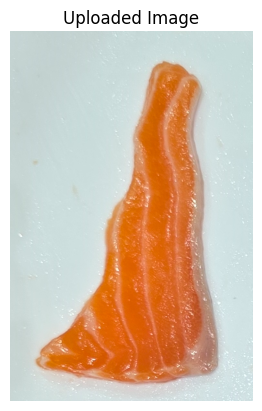

Predicted Class: 1 => Trout


In [23]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt

# ตั้งค่าอุปกรณ์
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = {0: "Salmon", 1: "Trout"}

# โหลดโมเดล (ให้ใช้ ResNet รเดียวกับตอนเทรน)
model = models.resnet34(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)  # เปลี่ยน output ตามที่ใช้ตอนเทรน
model.load_state_dict(torch.load("/content/model_fold_0.pth", map_location=device))
model = model.to(device)
model.eval()

# Transform เหมือนตอน train
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ถ้าใช้ ImageNet pretrained
                         [0.229, 0.224, 0.225])
])

# ฟังก์ชันอัปโหลดรูปและทำนาย
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    # โหลดและแปลงภาพ
    image = Image.open(filename).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # พล็อตภาพ
    plt.imshow(image)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    # ทำนาย
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        print(f"Predicted Class: {predicted.item()} => {class_names[predicted.item()]}")
